In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import nltk
import spacy
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Sajin.LAPTOP-
[nltk_data]     RE0DL8PH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

target
0    4342
1    3271
Name: count, dtype: int64


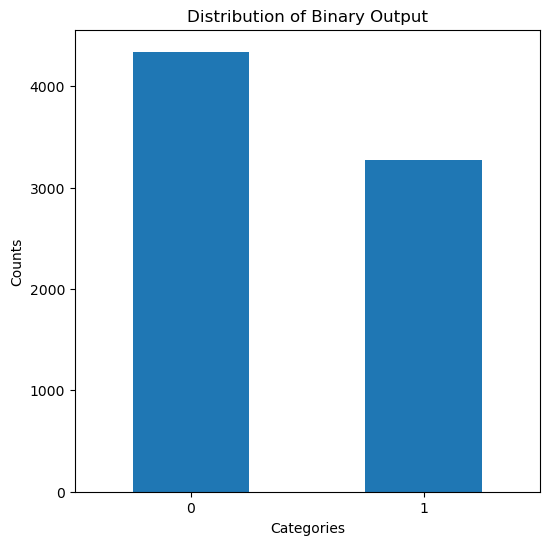

In [3]:
import matplotlib.pyplot as plt

# Calculate counts of each category
counts = train_data['target'].value_counts()
print(counts)

# Plotting
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')
plt.title('Distribution of Binary Output')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.show()

In [4]:
def combine_cols(df):
    df['new_text'] = df['text'].fillna('') + ' ' + df['location'].fillna('') + ' ' + df['keyword'].fillna('')
    return df
# train_data=combine_cols(train_data)
# test_data=combine_cols(test_data)

In [5]:
from twitter_clean import clean_text
train_data['clean_text']=train_data['text'].apply(clean_text)
test_data['clean_text']=test_data['text'].apply(clean_text)
train_data.to_csv('train_clean.csv',index=False)
test_data.to_csv('test_clean.csv',index=False)

In [6]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
#wn = nltk.WordNetLemmatizer()
def preprocessing(text):
    tokens=word_tokenize(text.lower().strip())
    filtered_tokens=[token for token in tokens if token not in stop_words]
    lemmatized_spacy = [token.lemma_ for token in nlp(" ".join(filtered_tokens))]
#     tokens = [wn.lemmatize(w) for w in word_tokenize(text.lower().strip()) if not w in stop_words]
    return " ".join(lemmatized_spacy)#' '.join(tokens)
train_data['preprocessed_text']=train_data['clean_text'].apply(preprocessing)
test_data['preprocessed_text']=test_data['clean_text'].apply(preprocessing)
train_data.to_csv('train_preprocessed.csv',index=False)
test_data.to_csv('test_preprocessed.csv',index=False)

In [7]:
df_mislabeled = train_data.groupby(['preprocessed_text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
mislabel_txt_list=df_mislabeled.index.tolist()
mislabel_txt_list

['',
 'governor weighs parole california school bus hijacker',
 'faan orders evacuation abandon aircraft mma',
 'fatality',
 'fedex long transport bioterror germ wake anthrax lab mishap',
 'feel like sink low self image take quiz',
 'fettilootch slanglucci oppression great danger come soon album',
 'fight bioterrorism sir',
 'fire hazard associate installation non compliant external cladding',
 'foodscare nestleindia slip loss magginoodle ban unsafe hazardous humanconsumption',
 'gm pray attack enemy derail destiny block lord flood life heavenly blessing',
 'hellfire even want think mention let we anything lead islam',
 'earthquake drill',
 'hellfire surround desire careful let desire control afterlife',
 'hillary mass murderer',
 'hollywood movie trap miner release chile',
 'hollywood movie trap miner release chile hollywood movie trap miner star',
 'horrible sinking feel home phone realise whole time',
 'hot c specially modify land stadium rescue hostage iran prebreak well',
 'hot fu

In [8]:
filtered_df = train_data[train_data['preprocessed_text'].isin(mislabel_txt_list)][['preprocessed_text','target']]
filtered_df

,preprocessed_text,target
246,united states national park services tonto nat...,0
248,world annihilation vs self transformation alie...,0
250,united states national park services tonto nat...,0
251,united states national park services tonto nat...,1
253,united states national park services tonto nat...,1
...,...,...
7379,texas seek comment rule change windstorm insurer,0
7391,twia board approve percent rate hike texas win...,0
7392,texas seek comment rule change windstorm insurer,0
7396,twia board approve percent rate hike texas win...,1


In [9]:
grouped_mean = filtered_df.groupby('preprocessed_text')['target'].mean().reset_index()
grouped_mean.to_csv('mislabled_correction.csv')

In [10]:
train_data['new_target']=train_data['target'].copy()
for index, row in grouped_mean.iterrows():
    text = row['preprocessed_text']
    target_mean =row['target']
    train_data.loc[train_data['preprocessed_text'] == text, 'new_target'] = 1 if target_mean >= 0.5 else 0
train_data.to_csv('train_new_label.csv',index=False)

In [11]:
counts = train_data['new_target'].value_counts()
print(counts)

new_target
0    4348
1    3265
Name: count, dtype: int64


In [12]:
deduplicated_df = train_data.drop_duplicates(subset=['preprocessed_text'])

# Optionally, reset the index
deduplicated_df = deduplicated_df.reset_index(drop=True)
deduplicated_df.to_csv('deduplicated.csv')
counts = deduplicated_df['new_target'].value_counts()
print(counts)

new_target
0    3970
1    2768
Name: count, dtype: int64


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
%matplotlib inline
x_train, x_test, y_train, y_test = train_test_split(train_data['preprocessed_text'],train_data['target'],stratify=train_data['target'],test_size=0.2,random_state=1)
count_vect = CountVectorizer()
tf_transformer = TfidfTransformer(use_idf=True) # just use tf, no idf used

# convert the text list to tfidf form matrix
x_train_counts = count_vect.fit_transform(x_train)
x_train_tf = tf_transformer.fit_transform(x_train_counts)
y_train = np.array(y_train)
clf = MultinomialNB(alpha=0.7)#BernoulliNB(alpha=0.9, fit_prior=True, class_prior=None)#1.11
clf.fit(x_train_tf, y_train) # train the classifier

# convert list to matrix
x_pre_counts = count_vect.transform(x_test)
x_pre_tf = tf_transformer.transform(x_pre_counts)

predicted = clf.predict(x_pre_tf)

In [14]:
metrics.accuracy_score(list(y_test), predicted)

0.8063033486539725

In [15]:
print(classification_report(list(y_test), predicted))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       869
           1       0.84      0.68      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [16]:
confusion_matrix(list(y_test), predicted)

array([[783,  86],
       [209, 445]], dtype=int64)

In [17]:
x_test_df = pd.DataFrame(x_test.values, columns=['text'], index=x_test.index)
y_test_df = pd.DataFrame(list(y_test), columns=['target'],index=x_test.index)
y_pred_df = pd.DataFrame(predicted, columns=['predicted_target'],index=x_test.index)
results = pd.concat([x_test_df, y_test_df, y_pred_df], axis=1)
results.to_csv('results.csv')

In [18]:
for item in count_vect.get_feature_names_out():
    print(item)

aa
aar
ab
aba
abandon
abbott
abc
abcnews
abe
aberdeen
abha
abia
ability
abject
ablaze
able
aboard
abomb
abomination
abortion
abouts
absence
absolute
absolutely
abstorm
abstract
absurd
abuse
ac
academia
acc
accept
accepte
access
accident
accidentally
accidentalprophecy
accompany
accord
accordingly
account
accountable
accuracy
accuse
accustomed
acdelco
ace
acenewsdesk
acesse
ache
achedin
achieve
achievement
achimota
acid
acoustic
acquiesce
acquire
acquisition
acre
acronym
across
acrylic
act
actavis
action
actionmoviestaughtus
activate
active
actively
activision
activist
activity
actor
actress
actual
actually
acura
acute
ad
adam
adamantly
adani
adaptation
add
addict
addiction
addition
address
adelaide
adhd
adidas
adjust
adjustable
adjusted
adjuster
admin
administration
administrative
admit
adopt
adoption
adoptive
adorable
adult
advance
advanced
advantage
adventure
adverse
advertise
advice
advise
advisory
aeg
aeroplane
aesop
aesthetic
af
afc
affair
affect
affected
affiliate
affiliation
aff

In [19]:
x_test_counts = count_vect.transform(test_data['preprocessed_text'])
x_test_tf = tf_transformer.transform(x_test_counts)
predicted = clf.predict(x_test_tf)

In [20]:
tem=pd.read_csv('sample_submission.csv')
tem['target']=predicted
tem.to_csv('test_prediction.csv',index=False)

In [21]:
perfect_score=pd.read_csv('submission.csv')
metrics.accuracy_score(list(perfect_score['target']), predicted)

0.7958933496782102

In [22]:
print(classification_report(list(perfect_score['target']), predicted))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1861
           1       0.83      0.67      0.74      1402

    accuracy                           0.80      3263
   macro avg       0.80      0.78      0.79      3263
weighted avg       0.80      0.80      0.79      3263



In [23]:
confusion_matrix(list(perfect_score['target']), predicted)

array([[1664,  197],
       [ 469,  933]], dtype=int64)

In [24]:
print(len(count_vect.get_feature_names_out()))

10182


In [25]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r